In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter

# Fonctions utilisées dans ce projet

In [3]:
def plot_acp_individuals(score, plan_indices, individual_names, class_labels, explained_variance):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        individual_names (array): Les noms des individus (ou labels).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points
    for i, name in enumerate(individual_names):
        plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True,axis='both')
    plt.show()

# Exemple d'utilisation de la fonction
# Vous devez fournir les données appropriées pour score, plan_indices, individual_names, class_labels et explained_variance.
# plot_acp_individuals(score, (0, 1), individual_names, class_labels, explained_variance)


#  Description du jeu de données.
Les donn ́ees ont  ́et ́e produites par l’Universit ́e d’Aix-Marseille,  ́equipe de Nathalie Dupuy. 
Des analyses proche infrarouge ont  ́et ́e r ́ealis ́ees sur les mˆemes 187 huiles d’olives que pour l’activit ́e du grain 03.
 Elles comprennent : 4
- un jeu de 187 spectres comprenant 612 longueurs d’onde, 1000 `a 2222 nm : pir.tab ;
     - un codage des 187  ́echantillons selon les 6 origines g ́eographiques avec des lettres :  AP=Aix en Provence, HP=Haute Provence, NI=Nice, NM=Nimes, NY=Nyons, VB=Vall ́ee des Baux de Provence; 
     - plus un autre codage avec des nombres : 1=Aix en Provence, 2=Haute Provence,
3=Nice, 4=Nimes, 5=Nyons, 6=Vall ́ee des Baux de Provence : labels2.tab.

# Import des données 


In [4]:
## importer les données 
infos = pd.read_csv("data/labels2.csv.csv")
spectres = pd.read_csv("data/pir.csv.csv")

infos.head()

,,code1,code2
0,AP01,1,AP
1,AP02,1,AP
2,AP03,1,AP
3,AP04,1,AP
4,AP05,1,AP


In [5]:
spectres.head()

,,1000,1002,1004,1006,1008,1010,1012,1014,1016,...,2204,2206,2208,2210,2212,2214,2216,2218,2220,2222
0,AP01,-0.048440,-0.048092,-0.047316,-0.046144,-0.045150,-0.043572,-0.042092,-0.040565,-0.040039,...,0.20674,0.20972,0.21389,0.21894,0.22447,0.23109,0.23900,0.24760,0.25572,0.26319
1,AP02,-0.039741,-0.039632,-0.039018,-0.037626,-0.036367,-0.035787,-0.034085,-0.032902,-0.031115,...,0.20709,0.20969,0.21348,0.21798,0.22370,0.23022,0.23842,0.24706,0.25568,0.26325
2,AP03,-0.044596,-0.044075,-0.043265,-0.042641,-0.041595,-0.039918,-0.038797,-0.036772,-0.035691,...,0.21084,0.21384,0.21781,0.22274,0.22816,0.23511,0.24303,0.25140,0.25961,0.26728
3,AP04,-0.046453,-0.046504,-0.045753,-0.044264,-0.043697,-0.042527,-0.041353,-0.039224,-0.038729,...,0.20320,0.20600,0.20954,0.21416,0.21955,0.22650,0.23430,0.24307,0.25165,0.25970
4,AP05,-0.047020,-0.046133,-0.044943,-0.044525,-0.043642,-0.041699,-0.040246,-0.039083,-0.037985,...,0.21023,0.21331,0.21699,0.22182,0.22742,0.23409,0.24198,0.25043,0.25854,0.26626


In [6]:
### recuperez les classes et les longueurs d'ondes spectres
wavelength = spectres.drop('  ',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
labels = infos['code2']
labels = labels.values
intensities = spectres.drop('  ',axis=1)
intensities = intensities.values
noms_individus = infos['  ']
noms_individus = noms_individus.values

# Exercice 1 : visualisation des données.

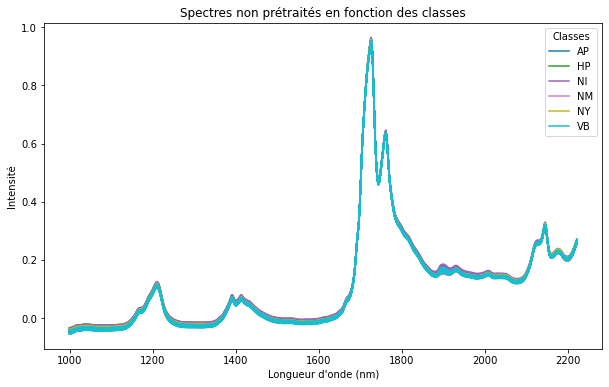

In [7]:

# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    label = labels[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(wavelength, intensities[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres non prétraités en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


### Observatioin des spectres n'ayant subit aucun prétraitements :
On observe aucune différence majeure ni de spectres se différenciant des autres.
# Exercice 2 : visualisation des points atypiques (outliers) d’une ACP.

In [8]:
pca = PCA( 10)
X = intensities
pca = pca.fit(X)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X)
score

array([[-4.20762272e-02,  1.52429233e-03, -2.90973552e-03, ...,
        -4.31125460e-03,  7.16686417e-04, -4.81284363e-03],
       [ 1.37553087e-01,  7.63108882e-03,  3.08740254e-03, ...,
        -1.76465953e-03,  2.96742503e-04, -1.92706841e-03],
       [ 5.84956582e-02, -1.17254595e-02, -6.75968139e-03, ...,
        -2.36165894e-03, -9.63949242e-04, -2.55163657e-03],
       ...,
       [ 1.08685418e-02,  2.01023429e-02,  2.06036926e-02, ...,
        -5.42620971e-04,  3.92998460e-05, -4.82764502e-04],
       [ 7.15849042e-02, -2.00496943e-02,  4.90373611e-03, ...,
         5.61226475e-04, -1.71625010e-03,  1.32978561e-03],
       [ 6.90971374e-03, -1.17528893e-02, -6.12676645e-06, ...,
        -1.63768885e-03, -1.33520695e-04, -4.02037643e-04]])

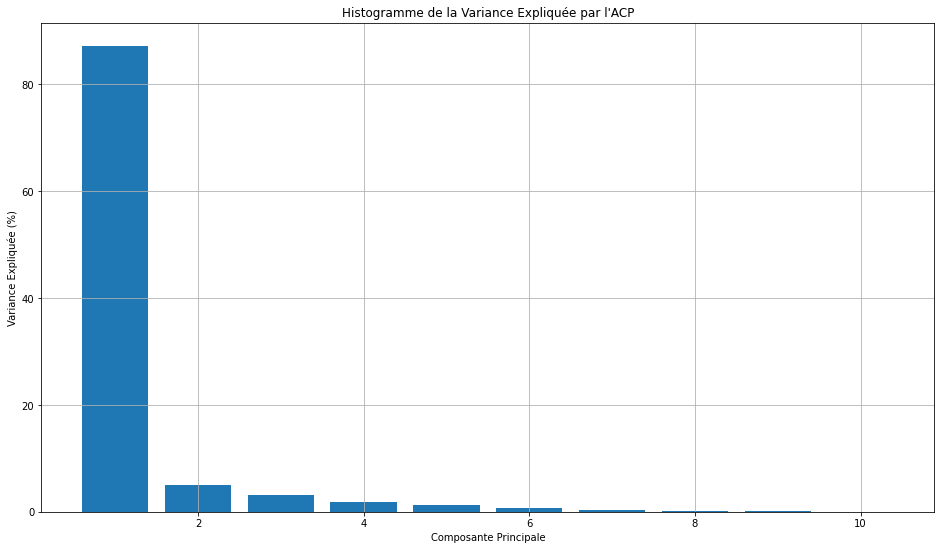

In [9]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

### Observation 
La variance expliquée par l'acp réalisé sur les spectres non traités montre que plus de 90% de la variance expliquée est résumé dans la composante 1 (pas du tout intéressant ça) le phénomène physique peut avoir pris le dessus sur le phénomène chimique.

### Visualisons la carte factoriel  des individus dans les plans (1,2) et plan (3,4)

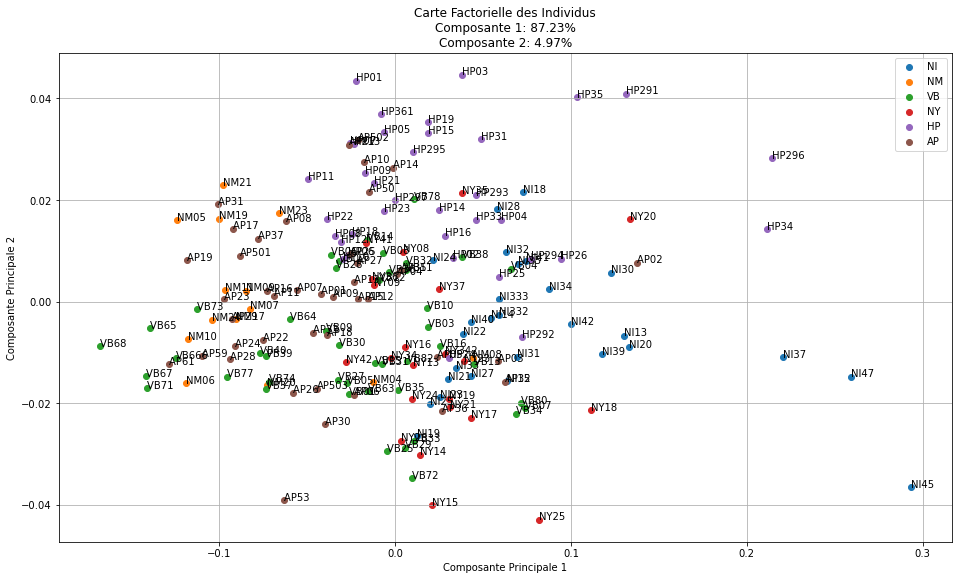

In [10]:
plot_acp_individuals(score=score, plan_indices=(0,1), individual_names=noms_individus, class_labels= labels , explained_variance = explained_variance )

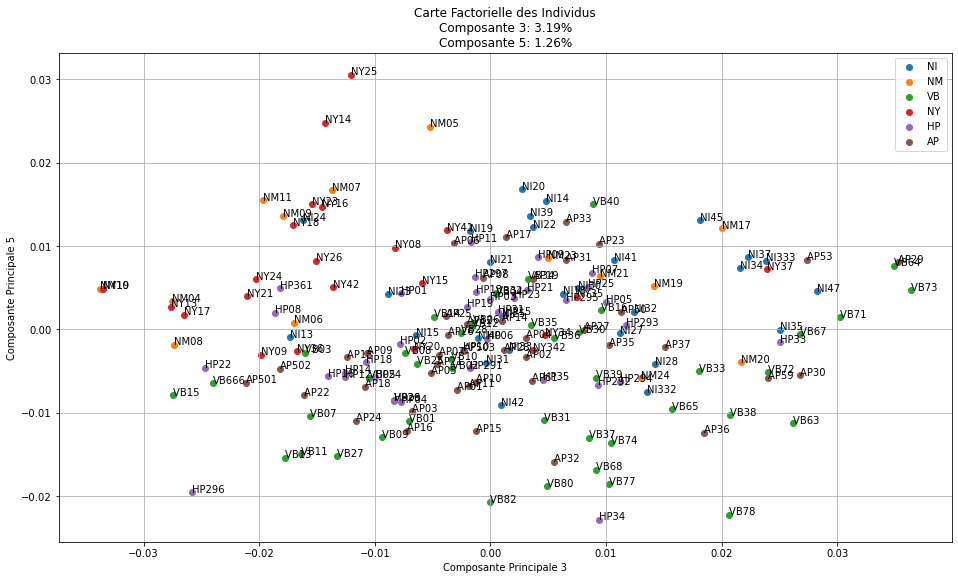

In [11]:
plot_acp_individuals(score=score, plan_indices=(2,4), individual_names=noms_individus, class_labels= labels , explained_variance = explained_variance )

### Observation:
- On arrive pas a distinguer des clusters d'individues liées à l'origine de l'huile
- On ne distingue pas d'outliers non plus 

# Exercice 3 : Spectres après prétraitement
 
### 1 er prétraitement : Supprimer la zone spectrale 1000-1148 nm.


In [12]:
## suppression des longeurs d'onde de la zone spectrale 1000-1148 nn
#### recuperons l'index des longueurs d'ondes a supprimer

start = 1000
end = 1148

# Récupérer les indices des éléments dans la plage (start, end)
indices_to_remove = np.where((wavelength >= start) & (wavelength <= end))[0]

# Supprimer les valeurs aux indices sélectionnés
filtered_wavelength = np.delete(wavelength, indices_to_remove)

# supprimer les valeurs aux indices sélectionnés au  niveau des intensities
filtered_intensity = [] ## intensité filtré  d'un seul spectre
filtered_intensities = [] ### toute les intensité filtrées des spectres
for i in range (len(intensities)):
    filtered_intensity= np.delete(intensities[i], indices_to_remove)
    filtered_intensities.append(filtered_intensity)
filtered_intensities = np.array(filtered_intensities) ## conversion en array
len(filtered_intensities)

187

### Appliquez le pretraitement Savitzky-Golay, derivee premiere, polynome de degre 2, fenetre de 7 points.

In [13]:
intensities_sg = savgol_filter(filtered_intensities,window_length=7,polyorder=2,deriv=1)


###  Appliquez le prétraitement SNV

#### Qu'est ce que la SNV?

La transformation Standard Normal Variate (SNV) est une technique couramment utilisée en chimiométrie, une discipline de la chimie qui se concentre sur l'analyse de données chimiques et spectrales. La SNV est utilisée pour prétraiter les données spectrales, en particulier dans le contexte de la spectroscopie infrarouge (IR) et de la spectroscopie de résonance magnétique nucléaire (RMN). Son objectif principal est de corriger les variations d'intensité dues à des différences dans la concentration ou l'épaisseur de l'échantillon, afin de mettre en évidence les variations spécifiques aux composants chimiques.

La transformation SNV est effectuée en deux étapes principales :

1. **Centrage des données** : Dans cette étape, la moyenne de chaque spectre est soustraite à chaque point de données du spectre. Cela permet de centrer les données autour de zéro.

2. **Mise à l'échelle des données** : Après le centrage, chaque point de données est divisé par l'écart type (la déviation standard) de la distribution des données pour chaque spectre. Cela standardise les données de sorte que chaque spectre ait une variance égale à 1.

La formule mathématique de la transformation SNV pour une donnée spectrale \(x\) est la suivante :

\[SNV(x) = \frac{x - \mu}{\sigma}\]

Où :
- \(SNV(x)\) est le spectre transformé SNV.
- \(x\) est le spectre original.
- \(\mu\) est la moyenne du spectre original.
- \(\sigma\) est l'écart type du spectre original.

Les avantages de la transformation SNV incluent la réduction de la variabilité due à des facteurs non chimiques (comme l'épaisseur de l'échantillon) et l'amélioration de la comparabilité entre les spectres. Cela rend plus facile la détection de tendances et de variations chimiques importantes dans les données spectrales.

La SNV est souvent utilisée en combinaison avec d'autres techniques de prétraitement de données, telles que la dérive basse, la correction de la dispersion, la normalisation multiplicative ou d'autres méthodes, en fonction des caractéristiques spécifiques des données spectrales et des objectifs de l'analyse chimiométrique.


In [14]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum


In [15]:
# Appliquer la transformation SNV à chaque spectre dans le tableau
snv_spectra = np.apply_along_axis(snv_spectrum, axis=1, arr=intensities_sg)
len(snv_spectra)

187

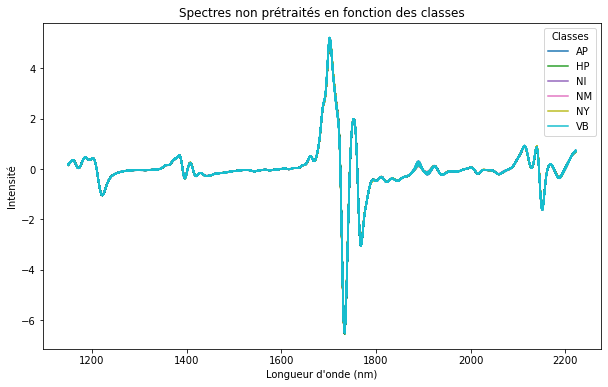

In [16]:
# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    label = labels[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength, snv_spectra[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres non prétraités en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


###  Réaliser une ACP sur le jeu précédent de données prétraitées, avec l’option centrage, sans l’option réduction.

In [17]:
pca = PCA( 10)
X = intensities_sg
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[-3.26221583e-04,  8.86081273e-05, -1.03337474e-03, ...,
        -2.33439449e-04,  9.19098928e-05, -3.95144887e-04],
       [ 1.92995944e-03, -4.75906303e-04, -1.33928466e-03, ...,
        -4.13881215e-04, -1.49031560e-04,  1.74557599e-04],
       [ 1.69269964e-03,  7.33491182e-05, -1.43695726e-03, ...,
        -5.55533919e-04, -5.19586178e-05, -1.17638560e-04],
       ...,
       [ 5.02117013e-03, -1.74099041e-03,  1.86003165e-03, ...,
         6.58925353e-05,  1.77768829e-04,  1.25940602e-04],
       [ 3.86941771e-03, -1.21670398e-03,  7.04782981e-04, ...,
        -8.71481364e-05, -3.97274265e-04, -1.67125810e-04],
       [ 3.69982009e-03, -3.56624843e-04,  1.12668295e-03, ...,
         1.94929114e-04,  1.30464250e-05, -5.64039922e-05]])

#### Tracer le diagramme de variance expliquée ?

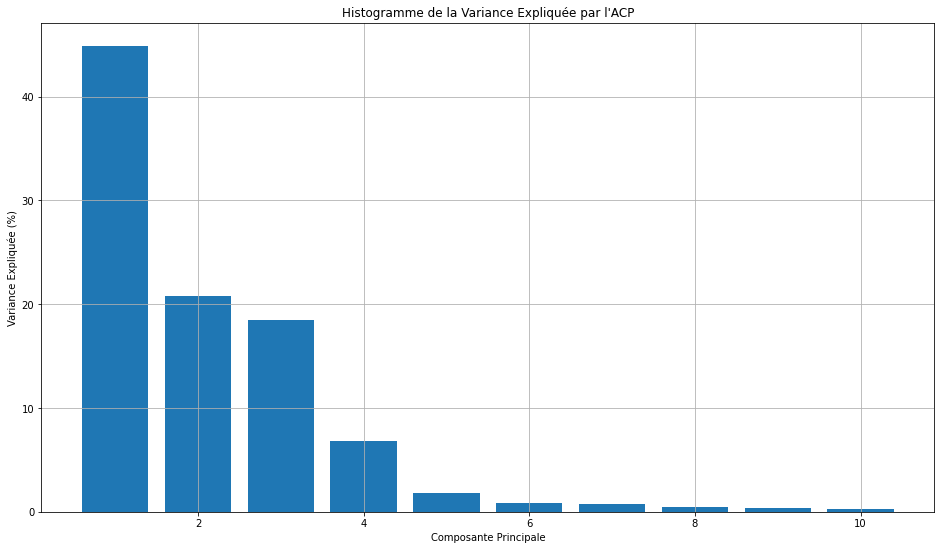

In [18]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

#### observation de l'hitogrammes des variances expliquées
- meilleures réparation des  variances expliquée sur différentes composantes après prétraitements des données
- on peut alors supposer que la variance expliquée par les différentes composantes est liées à un phénomène chimique que physique


## Tracer les plans 1-2 et 1-3 de la carte factorielle des individus (score plot).

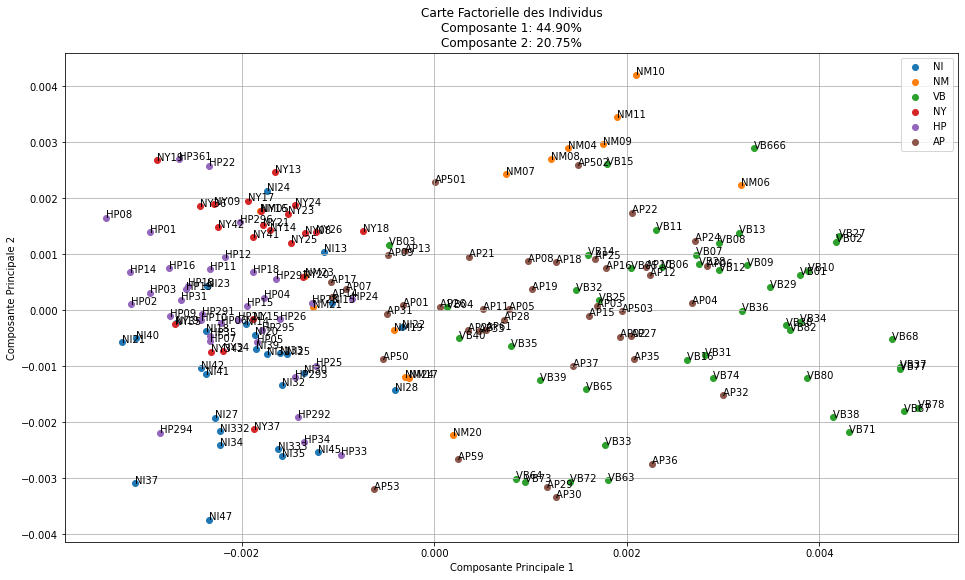

In [19]:
plot_acp_individuals(score = score, plan_indices=(0,1),individual_names= noms_individus ,class_labels= labels,explained_variance = explained_variance)

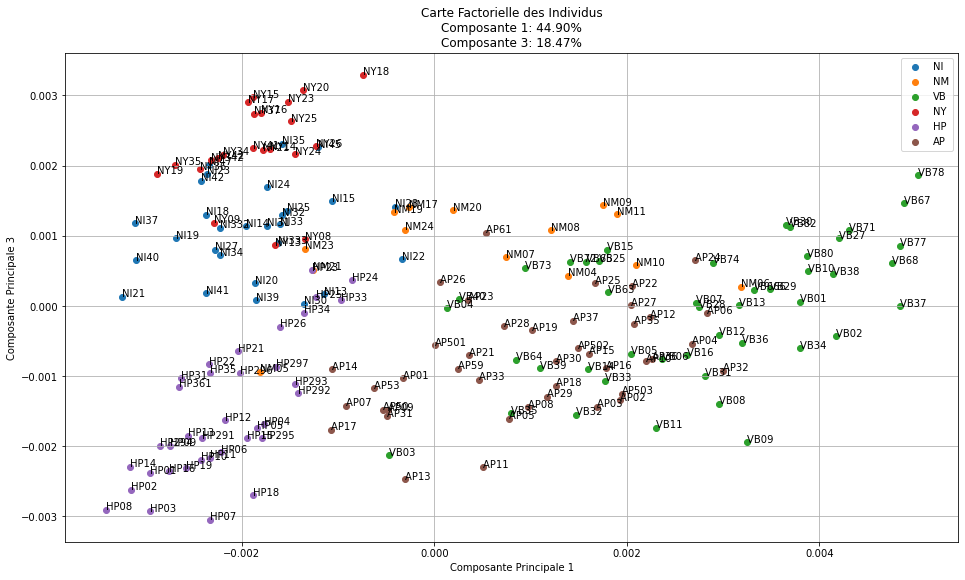

In [20]:
plot_acp_individuals(score = score, plan_indices=(0,2),individual_names= noms_individus ,class_labels= labels,explained_variance = explained_variance)

#### observation des cartes factoriels des individus plan 1-2 et plan 1-3

- Observe-t-on des outliers, si oui lesquels ? 
    - --> on observe pas d'outliers sur les deux plans 
- Peut-on différencier les diff ́erentes origines a` l’aide de cette visualisation ?  
    - --> Oui 
        - sur le plan (1-3) on voit que les huiles provenant de Haute provances (HP) en vert constitue un cluster de même pour les huilles provenant  de Noyon (NY) qui sont opposés selon la composante 3
        - De plus sur le plan (1-3) on distingue clairement chaque huile selon son origine

# FIN